
## Modello SVM per la classificazione 

In questo notebook viene valutata una **Support Vector Machine lineare (LinearSVC)** come modello alternativo alla Logistic Regression per la classificazione testuale dei ticket.
Le SVM lineari sono ampiamente utilizzate in ambito NLP per la loro capacità di gestire spazi di feature ad alta dimensionalità e per la loro efficacia su testi brevi e sparsi.

Obiettivi di questa sezione:
- Utilizzare il dataset già preprocessato `tickets_preprocessed_split.csv`
- Addestrare due modelli distinti:
  - Classificazione **categoria** (Amministrazione / Tecnico / Commerciale)
  - Classificazione **priorità** (bassa / media / alta)
- Utilizzare una pipeline **TF-IDF + LinearSVC** come modello di base
- Valutare le performance con:
  - Accuracy
  - F1 macro
  - Classification report
  - Matrice di confusione
- Estrarre le parole più influenti per ciascuna classe (utile per la dashboard)

L’obiettivo è confrontare questo approccio con la baseline logistica in termini di prestazioni e caratteristiche di interpretabilità, mantenendo invariata la struttura generale della pipeline.


In [1]:
import re
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_it = stopwords.words('italian')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import LinearSVC

from pathlib import Path

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lavezzidie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Caricamento del dataset preprocessato

Il dataset `../data/tickets_preprocessed_split.csv` contiene:
- testo originale (`title`, `body`)
- testo combinato (`text`)
- versione pulita del testo (`text_clean`)
- etichette (`category`, `priority`)
- colonna `split` che distingue **train** e **test**


In [2]:
# Carica il dataset preprocessato
df = pd.read_csv(DATA_DIR / "splits" / "tickets_preprocessed_split.csv")

# Controllo rapido delle colonne e delle prime righe
print(df.columns)
df.head()


Index(['id', 'title', 'body', 'category', 'priority', 'title_length',
       'body_length', 'text', 'text_clean', 'len_words_raw', 'len_words_clean',
       'split'],
      dtype='object')


,id,title,body,category,priority,title_length,body_length,text,text_clean,len_words_raw,len_words_clean,split
0,1,Archivio: documentazione storica 2012,Monitroaggio passivo dei log modulo gestione u...,Amministrazione,media,37,294,Archivio: documentazione storica 2012 Monitroa...,archivio documentazione storica 2012 monitroag...,45,44,train
1,2,err. validazione: codice fiscale corretto rifi...,tAtività di background: archiviazione documnet...,Amministrazione,bassa,63,331,err. validazione: codice fiscale corretto rifi...,err validazione codice fiscale corretto rifiut...,52,56,train
2,3,Batch: consolidamento dati contabili,Il sys. clienti non risponde alle richieste di...,Amministrazione,alta,36,367,Batch: consolidamento dati contabili Il sys. c...,batch consolidamento dati contabili il sys cli...,57,58,train
3,4,Monitoraggio: log modulo utenti (nessun errore),Mancata ricezione notifica approvazione ordine...,Amministrazione,media,47,238,Monitoraggio: log modulo utenti (nessun errore...,monitoraggio log modulo utenti nessun errore m...,38,41,train
4,5,"Log: inserimento anagrafica Smirnoff, Maschero...",Richiesta estrazione dati statistici su utiliz...,Amministrazione,bassa,67,303,"Log: inserimento anagrafica Smirnoff, Maschero...",log inserimento anagrafica smirnoff mascheroni...,48,47,train


In [3]:
# Verifica della colonna 'split'
df["split"].value_counts()

split
train    384
test      96
Name: count, dtype: int64


## Costruzione dei set di training e test

Separiamo feature e target usando `split`:
- `X_train` / `X_test`: testo pulito (`text_clean`)
- `y_train_cat` / `y_test_cat`: etichetta `category`
- `y_train_prio` / `y_test_prio`: etichetta `priority`

Come input testuale viene utilizzata la colonna `text_clean` contenente il testo già pulito.
Vengono verificare dimensioni e distribuzioni per assicurarsi che train e test restino comparabili.


In [4]:
# Feature testuale (già pulita)
X_train = df[df["split"] == "train"]["text_clean"]
X_test  = df[df["split"] == "test"]["text_clean"]

# Target per categoria
y_train_cat = df[df["split"] == "train"]["category"]
y_test_cat  = df[df["split"] == "test"]["category"]

# Target per priorità
y_train_prio = df[df["split"] == "train"]["priority"]
y_test_prio  = df[df["split"] == "test"]["priority"]

print("Dimensioni training:", X_train.shape[0])
print("Dimensioni test:", X_test.shape[0])

Dimensioni training: 384
Dimensioni test: 96


In [5]:
print("Distribuzione categoria - train:")
print(y_train_cat.value_counts(normalize=True).round(3))

print("\nDistribuzione categoria - test:")
print(y_test_cat.value_counts(normalize=True).round(3))

print("\nDistribuzione priorità - train:")
print(y_train_prio.value_counts(normalize=True).round(3))

print("\nDistribuzione priorità - test:")
print(y_test_prio.value_counts(normalize=True).round(3))

Distribuzione categoria - train:
category
Tecnico            0.448
Amministrazione    0.302
Commerciale        0.250
Name: proportion, dtype: float64

Distribuzione categoria - test:
category
Tecnico            0.458
Amministrazione    0.292
Commerciale        0.250
Name: proportion, dtype: float64

Distribuzione priorità - train:
priority
media    0.422
bassa    0.289
alta     0.289
Name: proportion, dtype: float64

Distribuzione priorità - test:
priority
media    0.417
bassa    0.292
alta     0.292
Name: proportion, dtype: float64


## Modello 1 – Classificazione **categoria** con TF-IDF + LinearSVC

In questo modello:
- Pulizia base del testo ed esclusione termini troppo rari o troppo frequenti con **min_df** e **max_df**
- Rappresentazione del testo: **TF-IDF** con uni- e bi-grammi
- Classificatore: **LinearSVC** multiclasse
- Gestione delle feature utilizzate: `max_features=200"`
- Gestione di possibili sbilanciamenti: `class_weight="balanced"`

Questa combinazione costituisce la **baseline** per la classificazione di categoria.

In [6]:
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        text = "" if text is None else str(text)
        
    # minuscole (e togli lowercase=False dal TFIDF)
    text = text.lower()
    
    # rimuovi solo simboli non utili
    text = re.sub(r"[^\w\sàèéìòù]", " ", text)
    
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [7]:
pipe_cat_svm = Pipeline([
    ("tfidf", TfidfVectorizer(
        preprocessor=clean_text,
        stop_words=stop_it,
        lowercase=True,
        ngram_range=(1, 2),
        max_features=200,
        min_df=2,             
        max_df=0.8,          
        strip_accents="unicode"
    )),
    ("clf", LinearSVC(
        class_weight="balanced",
        C=1.0,
        random_state=42
    ))
])

pipe_cat_svm


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...0022B7647C220>
,tokenizer,None


In [8]:
pipe_cat_svm.fit(X_train, y_train_cat)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...0022B7647C220>
,tokenizer,None



### Valutazione del modello per categoria

Metriche considerate:
- **Accuracy**: quota di predizioni corrette sul test set
- **F1 macro**: media dell'F1 calcolata separatamente su ciascuna classe (tutte le classi pesano uguale)
- **Classification report**: precision, recall, F1 per classe
- **Matrice di confusione**: errori per coppia (vera classe, classe predetta)


In [9]:
y_pred_cat_svm = pipe_cat_svm.predict(X_test)

acc_cat_svm = accuracy_score(y_test_cat, y_pred_cat_svm)
f1_cat_svm = f1_score(y_test_cat, y_pred_cat_svm, average="macro")

print(f"Accuracy SVM (categoria): {acc_cat_svm:.3f}")
print(f"F1 macro SVM (categoria): {f1_cat_svm:.3f}")

print("\nClassification report SVM (categoria):")
print(classification_report(y_test_cat, y_pred_cat_svm))


Accuracy SVM (categoria): 0.990
F1 macro SVM (categoria): 0.987

Classification report SVM (categoria):
                 precision    recall  f1-score   support

Amministrazione       1.00      0.96      0.98        28
    Commerciale       0.96      1.00      0.98        24
        Tecnico       1.00      1.00      1.00        44

       accuracy                           0.99        96
      macro avg       0.99      0.99      0.99        96
   weighted avg       0.99      0.99      0.99        96



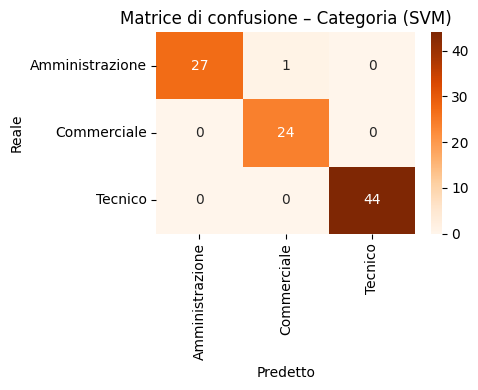

,Amministrazione,Commerciale,Tecnico
Amministrazione,27,1,0
Commerciale,0,24,0
Tecnico,0,0,44


In [10]:
labels_cat = sorted(y_train_cat.unique())

cm_cat_svm = confusion_matrix(y_test_cat, y_pred_cat_svm, labels=labels_cat)
cm_cat_svm_df = pd.DataFrame(cm_cat_svm, index=labels_cat, columns=labels_cat)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_cat_svm_df, annot=True, fmt="d", cmap="Oranges")
plt.title("Matrice di confusione – Categoria (SVM)")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.tight_layout()
plt.show()

cm_cat_svm_df


## Modello 2 – Classificazione **priorità** con TF-IDF + Logistic Regression

Replica dello stesso approccio utilizzato per la categoria, ma con target `priority`.

L’obiettivo è:
- capire quanto è più difficile stimare la priorità rispetto alla categoria
- confrontare le metriche delle due task (categoria vs priorità).


In [11]:
pipe_prio_svm = Pipeline([
    ("tfidf", TfidfVectorizer(        
        preprocessor=clean_text,
        stop_words=stop_it,
        lowercase=True,
        ngram_range=(1, 2),
        max_features=200,
        min_df=2,             
        max_df=0.8,
        strip_accents="unicode"
    )),
    ("clf", LinearSVC(
        class_weight="balanced",
        C=1.0,
        random_state=42
    ))
])

pipe_prio_svm


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...0022B7647C220>
,tokenizer,None


In [12]:
pipe_prio_svm.fit(X_train, y_train_prio)


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...0022B7647C220>
,tokenizer,None



### Valutazione SVM per priorità

Stesse metriche della sezione categoria:
- Accuracy
- F1 macro
- Classification report
- Matrice di confusione

Confronto immediato con la baseline logistica anche sul target `priority`.


In [13]:
y_pred_prio_svm = pipe_prio_svm.predict(X_test)

acc_prio_svm = accuracy_score(y_test_prio, y_pred_prio_svm)
f1_prio_svm = f1_score(y_test_prio, y_pred_prio_svm, average="macro")

print(f"Accuracy SVM (priorità): {acc_prio_svm:.3f}")
print(f"F1 macro SVM (priorità): {f1_prio_svm:.3f}")

print("\nClassification report SVM (priorità):")
print(classification_report(y_test_prio, y_pred_prio_svm))


Accuracy SVM (priorità): 0.885
F1 macro SVM (priorità): 0.889

Classification report SVM (priorità):
              precision    recall  f1-score   support

        alta       0.96      0.96      0.96        28
       bassa       0.76      0.93      0.84        28
       media       0.94      0.80      0.86        40

    accuracy                           0.89        96
   macro avg       0.89      0.90      0.89        96
weighted avg       0.90      0.89      0.89        96



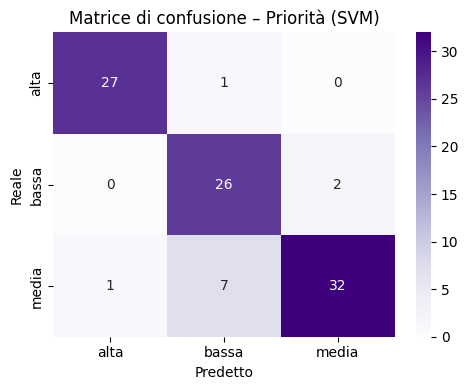

,alta,bassa,media
alta,27,1,0
bassa,0,26,2
media,1,7,32


In [14]:
labels_prio = sorted(y_train_prio.unique())

cm_prio_svm = confusion_matrix(y_test_prio, y_pred_prio_svm, labels=labels_prio)
cm_prio_svm_df = pd.DataFrame(cm_prio_svm, index=labels_prio, columns=labels_prio)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_prio_svm_df, annot=True, fmt="d", cmap="Purples")
plt.title("Matrice di confusione – Priorità (SVM)")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.tight_layout()
plt.show()

cm_prio_svm_df



## Feature più influenti per classe

Per rendere il modello interpretabile:
- vengono estratte le feature TF-IDF e i coefficienti del `LinearSVC`
- vengono mostrare le parole con peso maggiore per ogni classe (categoria/priorità)
- l'output alimenta la dashboard con le *top 5 parole* associate a ciascuna etichetta


In [15]:
# Estrazione componenti dalla pipeline
vec_cat = pipe_cat_svm.named_steps["tfidf"]
clf_cat = pipe_cat_svm.named_steps["clf"]

feature_names_cat = np.array(vec_cat.get_feature_names_out())
classes_cat = clf_cat.classes_

top_k = 5

for idx, cls in enumerate(classes_cat):
    coefs = clf_cat.coef_[idx]
    top_idx = np.argsort(coefs)[-top_k:]
    print(f"\nClasse categoria: {cls}")
    for i in reversed(top_idx):
        print(f"  {feature_names_cat[i]}  (peso: {coefs[i]:.3f})")



Classe categoria: Amministrazione
  fatture  (peso: 2.195)
  account  (peso: 1.892)
  licenze  (peso: 1.584)
  salvataggio  (peso: 1.352)
  validazione  (peso: 1.332)

Classe categoria: Commerciale
  cliente  (peso: 1.812)
  mese  (peso: 1.519)
  crm  (peso: 1.494)
  unificare  (peso: 1.454)
  indirizzo  (peso: 1.440)

Classe categoria: Tecnico
  ordini  (peso: 1.371)
  policy  (peso: 1.231)
  inviare  (peso: 1.203)
  inserimento ordini  (peso: 1.145)
  risposta  (peso: 1.078)


In [16]:
vec_prio = pipe_prio_svm.named_steps["tfidf"]
clf_prio = pipe_prio_svm.named_steps["clf"]

feature_names_prio = np.array(vec_prio.get_feature_names_out())
classes_prio = clf_prio.classes_

top_k = 5

for idx, cls in enumerate(classes_prio):
    coefs = clf_prio.coef_[idx]
    top_idx = np.argsort(coefs)[-top_k:]
    print(f"\nClasse priorità: {cls}")
    for i in reversed(top_idx):
        print(f"  {feature_names_prio[i]}  (peso: {coefs[i]:.3f})")



Classe priorità: alta
  bloccato  (peso: 4.023)
  urgente  (peso: 3.499)
  critico  (peso: 3.061)
  ordine urgente  (peso: 2.077)
  errore critico  (peso: 1.906)

Classe priorità: bassa
  storico  (peso: 1.551)
  anni  (peso: 1.381)
  attività  (peso: 1.210)
  monitoraggio  (peso: 1.142)
  passivo  (peso: 1.063)

Classe priorità: media
  errore  (peso: 1.327)
  iva  (peso: 1.320)
  interfaccia  (peso: 1.235)
  inserimento ordini  (peso: 1.015)
  problema  (peso: 0.999)



## Salvataggio delle metriche SVM

i risultati vengono esportati per essere riutilizzati nel notebook di confronto e nella dashboard:
- `svm_metrics.json` con accuracy/F1 macro per categoria e priorità
- `../data/results_baseline/confusion_*_svm.csv` con le matrici di confusione



In [17]:
import json

results_svm = {
    "categoria_accuracy": float(acc_cat_svm),
    "categoria_f1_macro": float(f1_cat_svm),
    "priorita_accuracy": float(acc_prio_svm),
    "priorita_f1_macro": float(f1_prio_svm)
}

with open(DATA_DIR / "results_baseline" / "svm_metrics.json", "w") as f:
    json.dump(results_svm, f, indent=4)


In [18]:
cm_cat_svm_df.to_csv(DATA_DIR / "results_baseline" / "confusion_cat_svm.csv", index=True)
cm_prio_svm_df.to_csv(DATA_DIR / "results_baseline" / "confusion_prio_svm.csv", index=True)

In [19]:
import numpy as np

TOP_N = 10
OUT_PATH = DATA_DIR / "results_baseline" / "topwords_svm.txt"
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)

def topwords_section(title, clf, classes, feature_names, top_n=10):
    lines = [f"\n{title}\n" + "=" * len(title)]

    if clf.coef_.shape[0] != len(classes):
        lines.append(
            "[WARN] LinearSVC non in modalità one-vs-rest: "
            "top words per classe non interpretabili in modo diretto."
        )
        return "\n".join(lines)

    for i, cls in enumerate(classes):
        coef = clf.coef_[i]
        top_idx = np.argsort(coef)[-top_n:][::-1]
        lines.append(f"\nClasse: {cls}")
        lines += [f"  - {feature_names[j]} ({coef[j]:.3f})" for j in top_idx]

    return "\n".join(lines)

content = (
    "Top words - LinearSVC\n"
    + topwords_section("Categoria", clf_cat, classes_cat, feature_names_cat, TOP_N)
    + topwords_section("Priorità", clf_prio, classes_prio, feature_names_prio, TOP_N)
    + "\n"
)

OUT_PATH.write_text(content, encoding="utf-8")
print(f"[OK] Salvato: {OUT_PATH}")


[OK] Salvato: C:\project-work\data\results_baseline\topwords_svm.txt
